In [1]:
import numpy as np
import random
import torch as T
import torch.nn as nn
import torch.nn.functional as TNF
import pyro as P
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as PD
from pyro.nn import PyroModule, PyroParam, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from matplotlib import pyplot as plt
from made import MADE


#class simpleNNNormal(nn.Module):
class simpleNNNormal(PyroModule):
    def __init__(self, input_size=1, hidden=16, out_size=1):
        super().__init__()
        self.hidden_layer = nn.Linear(input_size, hidden)
        self.loc_layer = nn.Linear(hidden, out_size)
        self.std_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        x = TNF.relu(self.hidden_layer(x_list))
        loc = self.loc_layer(x)
        std = self.std_layer(x)
        return loc, std

#class simpleNNHidden(nn.Module):
class simpleNNHidden(PyroModule):
    def __init__(self, input_size=1, hidden=16, out_size=1):
        super().__init__()
        self.hidden_layer = nn.Linear(input_size, hidden)
        self.out_layer = nn.Linear(hidden, out_size)

    def forward(self, x_list):
        x = TNF.relu(self.hidden_layer(x_list))
        return self.out_layer(x)

    


hid_size = 3

nn_model_core_hidden = simpleNNHidden(out_size=hid_size)
nn_q__i = simpleNNHidden(input_size=hid_size)
nn_xp__i = simpleNNNormal(input_size=hid_size)
nn_y2__i = simpleNNNormal(input_size=hid_size + 1)
nn_y1__i =  simpleNNNormal(input_size=hid_size + 1)
nn_core_hidden = simpleNNHidden(input_size=hid_size, out_size=hid_size)
#nn_core_hidden = simpleNNHidden(input_size=hid_size + 1, out_size=hid_size)

def core_guide(hidden, x, i=0):
    q__i_prob, = nn_q__i(hidden)
    q = P.sample(f'q_{i}', PD.Bernoulli(T.sigmoid(q__i_prob)))
    #cond = P.deterministic(f"cond_{i}", q < 0.5)
    #if cond:
    if q < 0.5:
        return x
    else:
        xp__i_mean, xp__i_std = nn_xp__i(hidden)
        xp = P.sample(f'xp_{i}', PD.Normal(xp__i_mean, TNF.softplus(xp__i_std)))
        y2__i_mean, y2__i_std = nn_y2__i(T.cat([hidden, T.tensor([xp])]))
        y2 = P.sample(f'y2_{i}', PD.Normal(y2__i_mean, TNF.softplus(y2__i_std)))
        y1__i_mean, y1__i_std = nn_y1__i(T.cat([hidden, T.tensor([y2])]))
        y1 = P.sample(f'y1_{i}', PD.Normal(y1__i_mean, TNF.softplus(y1__i_std)))
        return core_guide(nn_core_hidden(hidden), xp, i + 1) # nn_core_hidden should take x
        #return core_guide(nn_core_hidden(T.cat([hidden, T.tensor([q__i_prob])])), xp, i + 1) # nn_core_hidden should take x

def guide(obs):
    r = core_guide(nn_model_core_hidden(T.tensor([obs])), 0.0, i=0)

def core_model(x, i=0):
    q = P. sample (f"q_{i}", PD. Bernoulli (T. tensor (0.5)))
    if q < 0.5:
        return x
    else :
        y1 = P. sample (f'y1_{i}', PD.Normal(x, 0.1))
        y2 = P. sample (f'y2_{i}', PD.Normal(y1 , 0.1))
        xp = P. sample (f'xp_{i}', PD.Normal(y2 , 0.1))
        return core_model(xp , i+1) + x

def model(obs):
    r = core_model(0.0,i=0)
    return P.sample("r", PD.Normal(r ,0.01) , obs=obs)



[Step 10/1000] Immediate Loss: 2110.9619520869855 Accumlated Loss: 2951.849467602105
[Step 20/1000] Immediate Loss: 973.6240481713417 Accumlated Loss: 1713.6964239648282
[Step 30/1000] Immediate Loss: 1485.6919467043879 Accumlated Loss: 1180.4729788649977
[Step 40/1000] Immediate Loss: 726.8157479642332 Accumlated Loss: 643.2115756524355
[Step 50/1000] Immediate Loss: 316.1611751393974 Accumlated Loss: 534.2970951904952
[Step 60/1000] Immediate Loss: 320.1792986049502 Accumlated Loss: 524.7669781633539
[Step 70/1000] Immediate Loss: 683.9538292235136 Accumlated Loss: 548.902802329518
[Step 80/1000] Immediate Loss: 362.28683261334896 Accumlated Loss: 309.00640168625114
[Step 90/1000] Immediate Loss: 294.60905340120206 Accumlated Loss: 417.6848438283206
[Step 100/1000] Immediate Loss: 254.10776227951044 Accumlated Loss: 337.4529898861125
[Step 110/1000] Immediate Loss: 291.4583583278209 Accumlated Loss: 372.11173005085436
[Step 120/1000] Immediate Loss: 315.0875515118614 Accumlated Loss:

[Step 970/1000] Immediate Loss: 198.69333987397837 Accumlated Loss: 225.40723643643196
[Step 980/1000] Immediate Loss: 244.32742492296273 Accumlated Loss: 223.9421498099114
[Step 990/1000] Immediate Loss: 233.92163915143806 Accumlated Loss: 198.04013438928288
[Step 1000/1000] Immediate Loss: 205.01622632358337 Accumlated Loss: 262.51507707301903


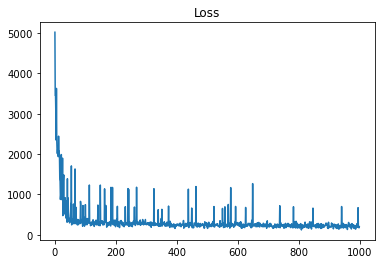

In [2]:
def gen_data(n=100):
    d = []
    for _ in range(n):
        d.append(model(obs=None))
    return d

data = gen_data()
P.clear_param_store()
num_data = len(data)
adam_params = {"lr": 0.001, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 1000
log_interval = 10
# do gradient steps
loss = 0
loss_track = []
for step in range(1, n_steps + 1):
    imme_loss = 0
    for obs in data:
        imme_loss += svi.step(obs) / num_data
    loss_track.append(imme_loss)
    loss += imme_loss / log_interval
    
    if step % log_interval == 0:
        print("[Step {}/{}] Immediate Loss: {} Accumlated Loss: {}".format(step, n_steps, imme_loss, loss))
        loss = 0

plt.plot(loss_track)
plt.title("Loss")
plt.show()